In [1]:
cd ../../

/Users/in-divye.singh/Documents/Projects/MIC_predictor


In [2]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from notebooks.utils import *
import importlib
import sys
importlib.reload(sys.modules['notebooks.utils'])
from notebooks.utils import *

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score

In [5]:
avp_ic50 = pd.read_csv("data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("data/raw/HA_AVP.csv")

df = pd.concat([avp_ic50[['Sequence', 'MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)
# df = df.sample(frac=1).reset_index(drop=True)

In [7]:
mic_threshold = 5
df['lessthan5'] = df['MIC'].apply(lambda mic: 1 if mic <= mic_threshold else 0)

In [8]:
dipep_freq = reduce_by_kmer_frequency(df, kmer=2)

In [9]:
uniprot_embedding = biovec.models.load_protvec("data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:00<00:00, 1196.20sequence/s]


In [10]:
dipep_protvec = pd.concat([avg_protvec, dipep_freq], axis=1)

## Cluster based analysis

### Silhouette analysis

In [12]:
avg_silhouette = silhouette_score(dipep_protvec, df['lessthan5'], metric='euclidean')
print(f"Silhouette score for the data: {avg_silhouette}")

Silhouette score for the data: 0.011773881741581478


<p style="font-size:20px;">The smaller value of Variance Ratio Criterion means that <b> the peptides are very loosely separated into high MIC value and low MIC value classes </b>. Let us look at the silhouette plot to see peptide wise silhouette values.</p>

In [13]:
sample_silhouette_values = silhouette_samples(dipep_protvec, df['lessthan5'], metric='euclidean')

In [15]:
n_clusters = 2

[]

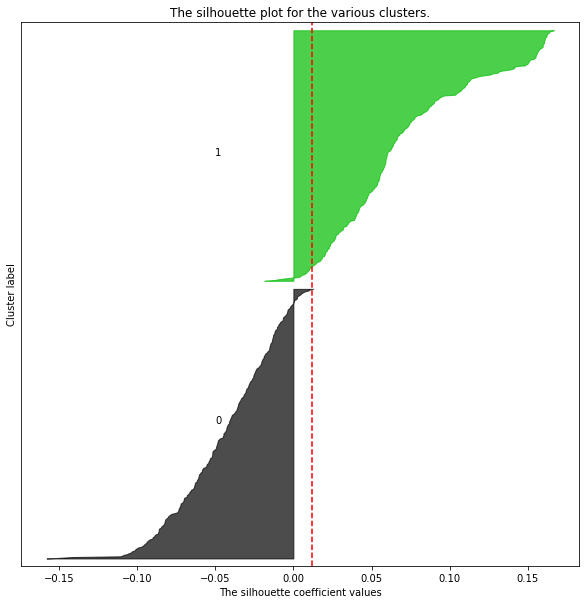

In [26]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,10))
ax1.set_ylim([0, dipep_protvec.shape[0] + (n_clusters + 1) * 10])

y_lower = 10
for i in range(n_clusters):
    ith_cluster_silhouette_values = sample_silhouette_values[df['lessthan5'] == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=avg_silhouette, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks

### Calinski and Harabasz score / Variance Ratio Criterion

In [30]:
vrc = calinski_harabasz_score(dipep_protvec, df['lessthan5'])
print(f"Variance Ratio Criterion for the data: {vrc}")

Variance Ratio Criterion for the data: 6.480034603092165


<p style="font-size:20px;">The smaller value of Variance Ratio Criterion means that <b> the peptides are very loosely separated into high MIC value and low MIC value classes </b>.</p>